<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/HER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install setuptools==65.5.0
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra] pyglet==1.5.27

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 https://developer.dow

# Stable baselines SAC

In [ ]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from gym.wrappers import TimeLimit

model_class = SAC  # works also with SAC, DDPG and TD3
N_BITS = 6

env = BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS)
env = TimeLimit(env, N_BITS)
                
# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy=goal_selection_strategy,
    ),
    verbose=1,
)

# Train the model
model.learn(50000)

model.save("./her_bit_env")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
model = model_class.load("./her_bit_env", env=env)

obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)

    if done:
        obs = env.reset()

Streaming output truncated to the last 5000 lines.
|    success_rate    | 1        |
| time/              |          |
|    episodes        | 9304     |
|    fps             | 66       |
|    time_elapsed    | 249      |
|    total_timesteps | 16490    |
| train/             |          |
|    actor_loss      | 0.144    |
|    critic_loss     | 0.04     |
|    ent_coef        | 0.0136   |
|    ent_coef_loss   | -4.75    |
|    learning_rate   | 0.0003   |
|    n_updates       | 16389    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.01     |
|    ep_rew_mean     | -0.01    |
|    success_rate    | 1        |
| time/              |          |
|    episodes        | 9308     |
|    fps             | 66       |
|    time_elapsed    | 249      |
|    total_timesteps | 16494    |
| train/             |          |
|    actor_loss      | 0.173    |
|    critic_loss     | 0.0381   |
|    ent_coef        | 0.0136  

KeyboardInterrupt: ignored

# Environment

In [ ]:
from collections import OrderedDict
from typing import Any, Dict, Optional, Union

import numpy as np
from gym import Env, spaces
from gym.envs.registration import EnvSpec

from stable_baselines3.common.type_aliases import GymStepReturn


class BitFlippingEnv(Env):
    """
    Simple bit flipping env, useful to test HER.
    The goal is to flip all the bits to get a vector of ones.
    In the continuous variant, if the ith action component has a value > 0,
    then the ith bit will be flipped.

    :param n_bits: Number of bits to flip
    :param continuous: Whether to use the continuous actions version or not,
        by default, it uses the discrete one
    :param max_steps: Max number of steps, by default, equal to n_bits
    :param discrete_obs_space: Whether to use the discrete observation
        version or not, by default, it uses the ``MultiBinary`` one
    :param image_obs_space: Use image as input instead of the ``MultiBinary`` one.
    :param channel_first: Whether to use channel-first or last image.
    """

    spec = EnvSpec("BitFlippingEnv-v0")

    def __init__(
        self,
        n_bits: int = 10,
        continuous: bool = False,
        max_steps: Optional[int] = None,
        discrete_obs_space: bool = False,
        image_obs_space: bool = False,
        channel_first: bool = True,
    ):
        super().__init__()
        # Shape of the observation when using image space
        self.image_shape = (1, 36, 36) if channel_first else (36, 36, 1)
        # The achieved goal is determined by the current state
        # here, it is a special where they are equal
        if discrete_obs_space:
            # In the discrete case, the agent act on the binary
            # representation of the observation
            self.observation_space = spaces.Dict(
                {
                    "observation": spaces.Discrete(2**n_bits),
                    "achieved_goal": spaces.Discrete(2**n_bits),
                    "desired_goal": spaces.Discrete(2**n_bits),
                }
            )
        elif image_obs_space:
            # When using image as input,
            # one image contains the bits 0 -> 0, 1 -> 255
            # and the rest is filled with zeros
            self.observation_space = spaces.Dict(
                {
                    "observation": spaces.Box(
                        low=0,
                        high=255,
                        shape=self.image_shape,
                        dtype=np.uint8,
                    ),
                    "achieved_goal": spaces.Box(
                        low=0,
                        high=255,
                        shape=self.image_shape,
                        dtype=np.uint8,
                    ),
                    "desired_goal": spaces.Box(
                        low=0,
                        high=255,
                        shape=self.image_shape,
                        dtype=np.uint8,
                    ),
                }
            )
        else:
            self.observation_space = spaces.Dict(
                {
                    "observation": spaces.MultiBinary(n_bits),
                    "achieved_goal": spaces.MultiBinary(n_bits),
                    "desired_goal": spaces.MultiBinary(n_bits),
                }
            )

        self.obs_space = spaces.MultiBinary(n_bits)

        if continuous:
            self.action_space = spaces.Box(-1, 1, shape=(n_bits,), dtype=np.float32)
        else:
            self.action_space = spaces.Discrete(n_bits)
        self.continuous = continuous
        self.discrete_obs_space = discrete_obs_space
        self.image_obs_space = image_obs_space
        self.state = None
        self.desired_goal = np.ones((n_bits,))
        if max_steps is None:
            max_steps = n_bits
        self.max_steps = max_steps
        self.current_step = 0

    def seed(self, seed: int) -> None:
        self.obs_space.seed(seed)

    def convert_if_needed(self, state: np.ndarray) -> Union[int, np.ndarray]:
        """
        Convert to discrete space if needed.

        :param state:
        :return:
        """
        if self.discrete_obs_space:
            # The internal state is the binary representation of the
            # observed one
            return int(sum(state[i] * 2**i for i in range(len(state))))

        if self.image_obs_space:
            size = np.prod(self.image_shape)
            image = np.concatenate((state * 255, np.zeros(size - len(state), dtype=np.uint8)))
            return image.reshape(self.image_shape).astype(np.uint8)
        return state

    def convert_to_bit_vector(self, state: Union[int, np.ndarray], batch_size: int) -> np.ndarray:
        """
        Convert to bit vector if needed.

        :param state:
        :param batch_size:
        :return:
        """
        # Convert back to bit vector
        if isinstance(state, int):
            state = np.array(state).reshape(batch_size, -1)
            # Convert to binary representation
            state = ((state[:, :] & (1 << np.arange(len(self.state)))) > 0).astype(int)
        elif self.image_obs_space:
            state = state.reshape(batch_size, -1)[:, : len(self.state)] / 255
        else:
            state = np.array(state).reshape(batch_size, -1)

        return state

    def _get_obs(self) -> Dict[str, Union[int, np.ndarray]]:
        """
        Helper to create the observation.

        :return: The current observation.
        """
        return OrderedDict(
            [
                ("observation", self.convert_if_needed(self.state.copy())),
                ("achieved_goal", self.convert_if_needed(self.state.copy())),
                ("desired_goal", self.convert_if_needed(self.desired_goal.copy())),
            ]
        )

    def reset(self) -> Dict[str, Union[int, np.ndarray]]:
        self.current_step = 0
        self.state = self.obs_space.sample()
        return self._get_obs()

    def step(self, action: Union[np.ndarray, int]) -> GymStepReturn:
        if self.continuous:
            self.state[action > 0] = 1 - self.state[action > 0]
        else:
            self.state[action] = 1 - self.state[action]
        obs = self._get_obs()
        reward = float(self.compute_reward(obs["achieved_goal"], obs["desired_goal"], None))
        done = reward == 0
        self.current_step += 1
        # Episode terminate when we reached the goal or the max number of steps
        info = {"is_success": done}
        done = done or self.current_step >= self.max_steps
        return obs, reward, done, info

    def compute_reward(
        self, achieved_goal: Union[int, np.ndarray], desired_goal: Union[int, np.ndarray], _info: Optional[Dict[str, Any]]
    ) -> np.float32:
        # As we are using a vectorized version, we need to keep track of the `batch_size`
        if isinstance(achieved_goal, int):
            batch_size = 1
        elif self.image_obs_space:
            batch_size = achieved_goal.shape[0] if len(achieved_goal.shape) > 3 else 1
        else:
            batch_size = achieved_goal.shape[0] if len(achieved_goal.shape) > 1 else 1

        desired_goal = self.convert_to_bit_vector(desired_goal, batch_size)
        achieved_goal = self.convert_to_bit_vector(achieved_goal, batch_size)

        # Deceptive reward: it is positive only when the goal is achieved
        # Here we are using a vectorized version
        distance = np.linalg.norm(achieved_goal - desired_goal, axis=-1)
        return -(distance > 0).astype(np.float32)

    def render(self, mode: str = "human") -> Optional[np.ndarray]:
        if mode == "rgb_array":
            return self.state.copy()
        print(self.state)

    def close(self) -> None:
        pass

In [ ]:
import sys
import gym
sys.modules[__name__]

gym.envs.register(
    id='BitFlippingEnv-v0',
    entry_point='__main__:BitFlippingEnv',
    max_episode_steps=10
)

# SAC Continuous

In [96]:
import gym
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch import distributions as pyd
import math

# Hyperparameters
BATCH_SIZE = 64
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
LR_ALPHA = 0.0003
STD_NOISE = 0.3
GAMMA = 0.99
TAU = 5e-3
BUFFER_SIZE = int(50000)
STEPS = 1000
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
DELAY_STEPS = 2
EPSILON = 1e-6
HER_PROBABILITY = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TanhTransform(pyd.transforms.Transform):
    domain = pyd.constraints.real
    codomain = pyd.constraints.interval(-1.0, 1.0)
    bijective = True
    sign = +1

    def __init__(self, cache_size=1):
        super().__init__(cache_size=cache_size)

    @staticmethod
    def atanh(x):
        return 0.5 * (x.log1p() - (-x).log1p())

    def __eq__(self, other):
        return isinstance(other, TanhTransform)

    def _call(self, x):
        return x.tanh()

    def _inverse(self, y):
        # We do not clamp to the boundary here as it may degrade the performance of certain algorithms.
        # one should use `cache_size=1` instead
        return self.atanh(y)

    def log_abs_det_jacobian(self, x, y):
        # We use a formula that is more numerically stable, see details in the following link
        # https://github.com/tensorflow/probability/commit/ef6bb176e0ebd1cf6e25c6b5cecdd2428c22963f#diff-e120f70e92e6741bca649f04fcd907b7
        return 2. * (math.log(2.) - x - F.softplus(-2. * x))

class SquashedNormal(pyd.transformed_distribution.TransformedDistribution):
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

        self.base_dist = pyd.Normal(loc, scale)
        transforms = [TanhTransform()]
        super().__init__(self.base_dist, transforms)

    @property
    def mean(self):
        mu = self.loc
        for tr in self.transforms:
            mu = tr(mu)
        return mu

class ActorNet(torch.nn.Module):
    def __init__(self, state_size, action_size, max_action):
        super(ActorNet, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.mu = torch.nn.Linear(128, action_size, device=device)
        self.sigma = torch.nn.Linear(128, action_size, device=device)
        self.max_action = torch.from_numpy(max_action).to(device)

        self.reset_parameters()

    def reset_parameters(self):
        x = self.fc1_init()
        self.fc1.weight.data.uniform_(x[0],x[1])
        x = self.fc2_init()
        self.fc2.weight.data.uniform_(x[0],x[1])

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # self.x1 = x
        x = F.relu(self.fc2(x))
        # self.x2 = x
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = torch.clamp(sigma, min=EPSILON, max=1)

        return mu, sigma

    def sample_normal(self, x, reparameterize=True):
      mu, sigma = self.forward(x)

    #   if torch.isnan(mu).any():
    #     print(self.x1)
    #     print(self.x2)
    #     print(x)
    #     print(mu)
    #     print(sigma)

      probabilities = SquashedNormal(mu, sigma)

      if reparameterize:
        actions = probabilities.rsample()
      else:
        actions = probabilities.sample()

      log_probabilities = probabilities.log_prob(actions).sum(-1, keepdim=True)
      action = torch.tanh(actions) * self.max_action
    #   log_probabilities -= torch.log(1-action.pow(2) + EPSILON)
    #   log_probabilities = log_probabilities.sum(1, keepdim=True)

      return action, log_probabilities

class CriticNet(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNet, self).__init__()

        self.fc1 = torch.nn.Linear(state_size + action_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.fc3 = torch.nn.Linear(128, 1, device=device)

        self.fc4 = torch.nn.Linear(state_size + action_size, 256, device=device)
        self.fc5 = torch.nn.Linear(256, 128, device=device)
        self.fc6 = torch.nn.Linear(128, 1, device=device)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.fc1_init())
        self.fc2.weight.data.uniform_(*self.fc2_init())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

        self.fc4.weight.data.uniform_(*self.fc1_init())
        self.fc5.weight.data.uniform_(*self.fc2_init())
        self.fc6.weight.data.uniform_(-3e-3, 3e-3)

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1).to(device)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        y = F.relu(self.fc4(state_action))
        y = F.relu(self.fc5(y))
        y = self.fc6(y)
        return x,y

    def Q1(self, state, action):
        state_action = torch.cat([state, action], 1).to(device)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SAC:
    def __init__(self, env):

        action_dim = env.action_space.shape[0]
        action_high = env.action_space.high
        state_dim = env.observation_space['observation'].n
        ag_dim = env.observation_space['achieved_goal'].n
        dg_dim = env.observation_space['desired_goal'].n

        self.actor = ActorNet(state_dim + dg_dim, action_dim, action_high)
        self.actor_target = ActorNet(state_dim + dg_dim, action_dim, action_high)
        self.critic = CriticNet(state_dim + dg_dim, action_dim)
        self.critic_target = CriticNet(state_dim + dg_dim, action_dim)
        self.memory = deque(maxlen=BUFFER_SIZE//2)
        self.her_memory = deque(maxlen=BUFFER_SIZE//2)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.action_high = action_high
        self.step = 0
        self.log_alpha = torch.tensor([-3.0], requires_grad=True, device=device)
        self.optimizer_logalpha = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        self.target_entropy = -action_dim

    def act(self, state):
        desired_state = np.hstack([state['observation'], state['desired_goal']])
        state = Variable(torch.from_numpy(desired_state).float().to(device).unsqueeze(0))
        self.actor.eval()
        with torch.no_grad():
            action, _ = self.actor.sample_normal(state.to(device), False)
        self.actor.train()
        return desired_state, np.clip(action.cpu().numpy()[0] * self.action_high, -self.action_high, self.action_high)

    def memorize(self, state, action, reward, next_state, done, her=False):
        if her:
            self.her_memory.append((state, action, reward, next_state, done))
        else:
            self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if (len(self.memory) + len(self.her_memory)) < BATCH_SIZE*2:
            return

        self.step += 1

        her_batch_size = int(BATCH_SIZE * HER_PROBABILITY)
        regular_batch_size = BATCH_SIZE - her_batch_size

        batch = random.sample(self.memory, regular_batch_size)
        her_batch = random.sample(self.her_memory, her_batch_size)
        full_batch = list(batch + her_batch)
        random.shuffle(full_batch)

        state_batch = torch.from_numpy(np.array([arr[0] for arr in full_batch])).float().to(device)
        action_batch = torch.from_numpy(np.array([arr[1] for arr in full_batch])).float().to(device)
        reward_batch = torch.from_numpy(np.array([arr[2] for arr in full_batch]).reshape(BATCH_SIZE, 1)).float().to(device)
        next_state_batch = torch.from_numpy(np.array([arr[3] for arr in full_batch])).float().to(device)
        done_batch = torch.from_numpy(np.array([arr[4] for arr in full_batch], dtype=np.uint8).reshape(BATCH_SIZE, 1)).float().to(device)

        alpha = torch.exp(self.log_alpha)

        next_actions, log_probs = self.actor_target.sample_normal(next_state_batch)
        q_next1, q_next2 = self.critic_target(next_state_batch, next_actions)
        target_V = torch.min(q_next1,q_next2) - alpha.detach() * log_probs
        q_targets = reward_batch + GAMMA * target_V * (1 - done_batch)

        # Update critic
        self.optimizer_critic.zero_grad()
        q_current1, q_current2 = self.critic(state_batch, action_batch)
        critic_loss = F.mse_loss(q_current1, q_targets) + F.mse_loss(q_current2, q_targets)
        critic_loss.backward()
        self.optimizer_critic.step()

        if self.step % DELAY_STEPS == 0:
          # Update actor
          self.optimizer_actor.zero_grad()
          next_actions, log_probs = self.actor.sample_normal(state_batch)
          q_next1, q_next2 = self.critic(state_batch, next_actions)
          actor_Q = torch.min(q_next1,q_next2)
          actor_loss = (alpha.detach() * log_probs - actor_Q).mean()
          actor_loss.backward()
          self.optimizer_actor.step()

          # Update log_alpha
          self.optimizer_logalpha.zero_grad()
          alpha_loss = (alpha *
                              (-log_probs - self.target_entropy).detach()).mean()
          alpha_loss.backward()
          self.optimizer_logalpha.step()

          # Update target networks
          self.update_targets()

    def update_targets(self):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

In [97]:
if __name__ == "__main__":
    env = BitFlippingEnv(n_bits=N_BITS, continuous=True, max_steps=N_BITS)
    env = TimeLimit(env, N_BITS)
    agent = SAC(env)
    scores = np.array([])
    for i_episode in range(1, 10000):
        state = env.reset()
        score = 0
        for t in range(10):
            achieved_state = np.hstack([state['observation'], state['achieved_goal']])
            desired_state, action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            next_desired_state = np.hstack([next_state['observation'], next_state['desired_goal']])
            next_achieved_state = np.hstack([next_state['observation'], next_state['achieved_goal']])
            agent.memorize(desired_state, action, reward, next_desired_state, done)
            score += reward
            reward = float(env.compute_reward(next_state['achieved_goal'], next_state['achieved_goal'], None))
            agent.memorize(achieved_state, action, reward, next_achieved_state, done, her=True)
            agent.learn()
            state = next_state
            if done:
                break
        scores = np.append(scores, score)
        if i_episode % 100 == 0 and i_episode != 0:
            print(f"Episode {(i_episode-100)}-{i_episode}: Score = {scores[i_episode-100:i_episode].mean()}")

Episode 0-100: Score = -5.89
Episode 100-200: Score = -5.72
Episode 200-300: Score = -5.51
Episode 300-400: Score = -5.75
Episode 400-500: Score = -5.78
Episode 500-600: Score = -5.66
Episode 600-700: Score = -5.33
Episode 700-800: Score = -4.62
Episode 800-900: Score = -4.39
Episode 900-1000: Score = -4.25
Episode 1000-1100: Score = -3.12
Episode 1100-1200: Score = -3.06
Episode 1200-1300: Score = -1.93
Episode 1300-1400: Score = -1.55
Episode 1400-1500: Score = -0.79
Episode 1500-1600: Score = -0.77
Episode 1600-1700: Score = -0.62
Episode 1700-1800: Score = -0.45
Episode 1800-1900: Score = -0.45
Episode 1900-2000: Score = -0.38
Episode 2000-2100: Score = -0.4
Episode 2100-2200: Score = -0.3
Episode 2200-2300: Score = -0.41
Episode 2300-2400: Score = -0.29
Episode 2400-2500: Score = -0.24
Episode 2500-2600: Score = -0.22
Episode 2600-2700: Score = -0.17
Episode 2700-2800: Score = -0.16
Episode 2800-2900: Score = -0.08
Episode 2900-3000: Score = -0.09
Episode 3000-3100: Score = -0.04


# DQN

Double Q-Learning

In [ ]:
%%bash

apt-get install swig

# git clone https://github.com/pybox2d/pybox2d
# cd pybox2d
# python setup.py build
# python setup.py install

apt-get install -y xvfb

pip install \
    gym \
    gym[box2d] \
    pytorch-lightning==1.6.0 \
    pyglet==1.5.27 \
    pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 1,086 kB of archives.
After this operation, 5,413 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig4.0 amd64 4.0.1-5build1 [1,081 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig all 4.0.1-5build1 [5,528 B]
Fetched 1,086 kB in 1s (1,355 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 128322 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.1-5build1_amd64.deb ...
Unpacki

In [ ]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions),
    )

  def forward(self, x):
    return self.net(x.float()) #.float() to be sure that input is float

In [ ]:
# fn:state -> [p1, p2, p3, p4] probabilities of selecting each of the actions

# here: fn:state -> action

def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else: # with probability 1 - epsilon
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1) # _ is the highest value, action is
    # the index
    action = int(action.item()) #.item() converts it from a PyTorch tensor 
    # into a python integer

    # In future we will have batches of state, and for each of these states,
    # a vector of q-values will be produced and the maximum value has to be 
    # taken inside each of those vectors independently.
    # For each of them, we want to take the best action.

  return action

In [ ]:
def create_environment(name):
  env = gym.make(name, n_bits=6)
  env = RecordEpisodeStatistics(env) # Keeps a history of the rewards
  return env

In [ ]:
class ReplayBuffer: 

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity//2)
    self.her_buffer = deque(maxlen=capacity//2)

  def __len__(self):
    return len(self.buffer + self.her_buffer)

  def append(self, experience, her=False):
    if her:
        self.her_buffer.append(experience)
    else:
        self.buffer.append(experience)

  def sample(self, batch_size, her_probability=0.8):
    her_batch_size = int(batch_size * her_probability)
    regular_batch_size = batch_size - her_batch_size

    batch = random.sample(self.buffer, regular_batch_size)
    her_batch = random.sample(self.her_buffer, her_batch_size)
    full_batch = list(batch + her_batch)
    random.shuffle(full_batch)

    return full_batch

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [ ]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, 
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, 
               eps_end=0.15, eps_last_episode=100, samples_per_epoch=10_000, 
               sync_rate=10):
    
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space['observation'].shape[0]
    ag_size = self.env.observation_space['achieved_goal'].shape[0]
    dg_size = self.env.observation_space['desired_goal'].shape[0]

    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size+ag_size, n_actions)

    # A copy that will be used to compute stable targets
    # Will update the values in this copy every sync_rate epochs
    self.target_q_net = copy.deepcopy(self.q_net) 

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch*2:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad() # We have a policy
  # If we dont include this, action will participate in the learning process
  def play_episode(self, policy=None, epsilon=0.):
    state = self.env.reset()
    desired_state = np.hstack([state['observation'], state['desired_goal']])
    achieved_state = np.hstack([state['observation'], state['achieved_goal']])
    done = False

    while not done:
      if policy:
        action = policy(desired_state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      next_desired_state = np.hstack([next_state['observation'], next_state['desired_goal']])
      next_achieved_state = np.hstack([next_state['observation'], next_state['achieved_goal']])

      exp = (desired_state, action, reward, done, next_desired_state)
    #   print('old:')
    #   print(reward)
    #   print('new:')
      reward = float(self.env.compute_reward(next_state['achieved_goal'], next_state['achieved_goal'], None))
    #   print(reward)
      exp_her = (achieved_state, action, reward, done, next_achieved_state)

      self.buffer.append(exp)
      self.buffer.append(exp_her, her=True)
      state = next_state

  def forward(self, x):
    return self.q_net(x)

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), 
                                         lr=self.hparams.lr)
    return [q_net_optimizer] # We might have multiple neural networks, hence
                             # multiple optimizers

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    states, actions, rewards, dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # Gather on the first dimension, the values of the actions taken
    state_action_values = self.q_net(states).gather(1, actions)
    
    # ADDED
    with torch.no_grad():
      # Selects the action to be taken
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # Estimates the value of those actions
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      # ADDED
      
      # It will give estimated by default (the real result is 0.0, and we know this)
      next_action_values[dones] = 0.0 

    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-error', loss)
    return loss

  def training_epoch_end(self, outputs):
    # Decreasing as we go forward    
    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.play_episode(policy=self.policy, epsilon=epsilon)
    # RecordStatistics keeps data in return_queue
    self.log('episode/Return', self.env.return_queue[-1])

    # The targets would be more stable after this
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

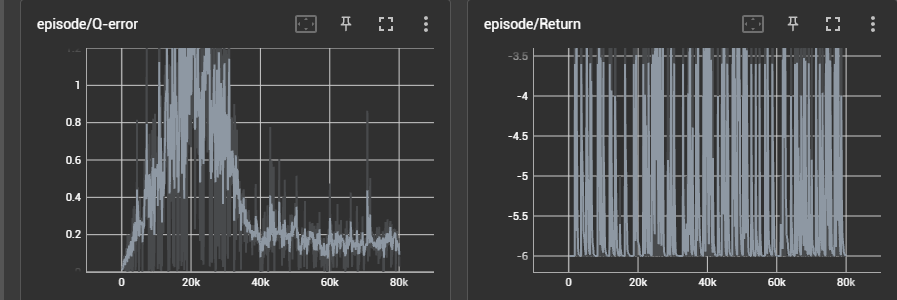

In [ ]:
env = create_environment("BitFlippingEnv-v0")

In [ ]:
obs = env.reset()
obs

OrderedDict([('observation', array([0, 0, 1, 1, 1, 1], dtype=int8)),
             ('achieved_goal', array([0, 0, 1, 1, 1, 1], dtype=int8)),
             ('desired_goal', array([1., 1., 1., 1., 1., 1.]))])

In [ ]:
algo = DeepQLearning('BitFlippingEnv-v0')

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=2000,
    # callbacks=[EarlyStopping(monitor='episode/Return', mode='max', patience=1000)]
)

trainer.fit(algo)

0 samples in experience buffer. Filling...
10 samples in experience buffer. Filling...
22 samples in experience buffer. Filling...
34 samples in experience buffer. Filling...
46 samples in experience buffer. Filling...
58 samples in experience buffer. Filling...
70 samples in experience buffer. Filling...
82 samples in experience buffer. Filling...
94 samples in experience buffer. Filling...
106 samples in experience buffer. Filling...
118 samples in experience buffer. Filling...
120 samples in experience buffer. Filling...
132 samples in experience buffer. Filling...
144 samples in experience buffer. Filling...
154 samples in experience buffer. Filling...
166 samples in experience buffer. Filling...
178 samples in experience buffer. Filling...
190 samples in experience buffer. Filling...
202 samples in experience buffer. Filling...
214 samples in experience buffer. Filling...
226 samples in experience buffer. Filling...
238 samples in experience buffer. Filling...
250 samples in exper

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 18.9 K
1 | target_q_net | DQN  | 18.9 K
--------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimated model params size (MB)


19338 samples in experience buffer. Filling...
19350 samples in experience buffer. Filling...
19362 samples in experience buffer. Filling...
19374 samples in experience buffer. Filling...
19380 samples in experience buffer. Filling...
19392 samples in experience buffer. Filling...
19404 samples in experience buffer. Filling...
19416 samples in experience buffer. Filling...
19428 samples in experience buffer. Filling...
19440 samples in experience buffer. Filling...
19452 samples in experience buffer. Filling...
19464 samples in experience buffer. Filling...
19476 samples in experience buffer. Filling...
19488 samples in experience buffer. Filling...
19500 samples in experience buffer. Filling...
19512 samples in experience buffer. Filling...
19524 samples in experience buffer. Filling...
19528 samples in experience buffer. Filling...
19540 samples in experience buffer. Filling...
19552 samples in experience buffer. Filling...
19564 samples in experience buffer. Filling...
19576 samples

Training: 0it [00:00, ?it/s]

# SAC Discrete

In [101]:
import gym
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from torch.autograd import Variable
from torch.distributions import Normal, Categorical
from torch import distributions as pyd
import math

# Hyperparameters
BATCH_SIZE = 64
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
LR_ALPHA = 0.0003
STD_NOISE = 0.3
GAMMA = 0.99
TAU = 5e-3
BUFFER_SIZE = int(50000)
STEPS = 1000
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
DELAY_STEPS = 2
EPSILON = 1e-6
HER_PROBABILITY = 0.8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
def create_actor_distribution(action_types, actor_output, action_size):
    """Creates a distribution that the actor can then use to randomly draw actions"""
    if action_types == "DISCRETE":
        assert actor_output.size()[1] == action_size, "Actor output the wrong size"
        action_distribution = Categorical(actor_output)  # this creates a distribution to sample from
    else:
        assert actor_output.size()[1] == action_size * 2, "Actor output the wrong size"
        means = actor_output[:, :action_size].squeeze(0)
        stds = actor_output[:,  action_size:].squeeze(0)
        if len(means.shape) == 2: means = means.squeeze(-1)
        if len(stds.shape) == 2: stds = stds.squeeze(-1)
        if len(stds.shape) > 1 or len(means.shape) > 1:
            raise ValueError("Wrong mean and std shapes - {} -- {}".format(stds.shape, means.shape))
        action_distribution = Normal(means.squeeze(0), torch.abs(stds))
    return action_distribution

In [110]:
class ActorNetDiscrete(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorNetDiscrete, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.out = torch.nn.Linear(128, action_size, device=device)
        self.action_size = action_size

        self.reset_parameters()

    def reset_parameters(self):
        x = self.fc1_init()
        self.fc1.weight.data.uniform_(x[0],x[1])
        x = self.fc2_init()
        self.fc2.weight.data.uniform_(x[0],x[1])

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
            # print(x)
        x = F.relu(self.fc2(x))

        action_probs = torch.softmax(self.out(x), dim=-1)
        if action_probs.isnan().any():
            print('debug_in1')
            print(self.fc1.weight)

        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)

        action_distribution = create_actor_distribution("DISCRETE", action_probs, self.action_size)

        return action_distribution.sample(), action_probs, log_action_probs

class CriticNetDiscrete(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetDiscrete, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.fc3 = torch.nn.Linear(128, action_size, device=device)

        self.fc4 = torch.nn.Linear(state_size, 256, device=device)
        self.fc5 = torch.nn.Linear(256, 128, device=device)
        self.fc6 = torch.nn.Linear(128, action_size, device=device)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.fc1_init())
        self.fc2.weight.data.uniform_(*self.fc2_init())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

        self.fc4.weight.data.uniform_(*self.fc1_init())
        self.fc5.weight.data.uniform_(*self.fc2_init())
        self.fc6.weight.data.uniform_(-3e-3, 3e-3)

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        y = F.relu(self.fc4(state))
        y = F.relu(self.fc5(y))
        y = self.fc6(y)
        return x,y

class SACDiscrete:
    def __init__(self, env):
        action_dim = env.action_space.n

        state_dim = env.observation_space['observation'].shape[0]
        ag_dim = env.observation_space['achieved_goal'].shape[0]
        dg_dim = env.observation_space['desired_goal'].shape[0]

        self.actor = ActorNetDiscrete(state_dim + dg_dim, action_dim)
        self.actor_target = ActorNetDiscrete(state_dim + dg_dim, action_dim)
        self.critic = CriticNetDiscrete(state_dim + dg_dim, action_dim)
        self.critic_target = CriticNetDiscrete(state_dim + dg_dim, action_dim)
        self.memory = deque(maxlen=BUFFER_SIZE//2)
        self.her_memory = deque(maxlen=BUFFER_SIZE//2)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.step = 0
        # self.log_alpha = torch.tensor([10.0], requires_grad=True, device=device)
        # self.optimizer_logalpha = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        self.target_entropy = -action_dim

    def act(self, state):
        desired_state = np.hstack([state['observation'], state['desired_goal']])
        state = Variable(torch.from_numpy(desired_state).float().to(device).unsqueeze(0))
        self.actor.eval()
        with torch.no_grad():
            action, _, _ = self.actor(state.to(device))
        self.actor.train()
        return desired_state, action

    def memorize(self, state, action, reward, next_state, done, her=False):
        if her:
            self.her_memory.append((state, action, reward, next_state, done))
        else:
            self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if (len(self.memory) + len(self.her_memory)) < BATCH_SIZE*2:
            return

        alpha_val = max(
            0.01,
            (1 - self.step / 2000)*0.05
        )

        self.step += 1

        her_batch_size = int(BATCH_SIZE * HER_PROBABILITY)
        regular_batch_size = BATCH_SIZE - her_batch_size

        batch = random.sample(self.memory, regular_batch_size)
        her_batch = random.sample(self.her_memory, her_batch_size)
        full_batch = list(batch + her_batch)
        random.shuffle(full_batch)

        state_batch = torch.from_numpy(np.array([arr[0] for arr in full_batch])).float().to(device)
        action_batch = torch.from_numpy(np.array([arr[1] for arr in full_batch])).float().to(device).unsqueeze(dim=-1)
        reward_batch = torch.from_numpy(np.array([arr[2] for arr in full_batch]).reshape(BATCH_SIZE, 1)).float().to(device)
        next_state_batch = torch.from_numpy(np.array([arr[3] for arr in full_batch])).float().to(device)
        done_batch = torch.from_numpy(np.array([arr[4] for arr in full_batch], dtype=np.uint8).reshape(BATCH_SIZE, 1)).float().to(device)


        alpha = torch.tensor([alpha_val], device=device)
        # alpha = self.log_alpha

        next_actions, action_probs, log_action_probs = self.actor_target(next_state_batch)
  
        next_actions = next_actions.unsqueeze(dim=-1)
        q_next1, q_next2 = self.critic_target(next_state_batch)
        # log(next_actions) is log_probs in this case
        target_V = (action_probs * (torch.min(q_next1,q_next2) - alpha.detach() * log_action_probs)).sum(dim=1, keepdims=True)
        q_targets = reward_batch + GAMMA * target_V * (1 - done_batch)

        # Update critic
        self.optimizer_critic.zero_grad()
        q_current1, q_current2 = self.critic(state_batch)
        critic_loss = F.mse_loss(q_current1.gather(1, action_batch.long()), q_targets) + F.mse_loss(q_current2.gather(1, action_batch.long()), q_targets)
        critic_loss.backward()
        self.optimizer_critic.step()

        if self.step % 2 == 0:
          # Update actor
          self.optimizer_actor.zero_grad()
          next_actions, action_probs, log_action_probs = self.actor(state_batch)
          next_actions = next_actions.unsqueeze(dim=-1)
          q_next1, q_next2 = self.critic(state_batch)
          actor_Q = torch.min(q_next1,q_next2)
          actor_loss = (action_probs * (alpha.detach() * log_action_probs - actor_Q)).sum(dim=1).mean()
          actor_loss.backward()
          self.optimizer_actor.step()

          # Update log_alpha
        #   self.optimizer_logalpha.zero_grad()
        #   alpha_loss = (action_probs.detach() * (-1 * alpha) *
        #                       (log_action_probs.detach() + self.target_entropy)).sum(dim=1).mean()
        #   alpha_loss.backward()
        #   self.optimizer_logalpha.step()

          # Update target networks
          self.update_targets()

    def update_targets(self):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

In [111]:
if __name__ == "__main__":
    env = BitFlippingEnv(n_bits=N_BITS, continuous=False, max_steps=N_BITS)
    env = TimeLimit(env, N_BITS)
    agent = SACDiscrete(env)
    scores = np.array([])
    for i_episode in range(1, 10000):
        state = env.reset()
        score = 0
        for t in range(10):
            achieved_state = np.hstack([state['observation'], state['achieved_goal']])
            desired_state, action = agent.act(state)
            next_state, reward, done, info = env.step(action.item())
            next_desired_state = np.hstack([next_state['observation'], next_state['desired_goal']])
            next_achieved_state = np.hstack([next_state['observation'], next_state['achieved_goal']])
            agent.memorize(desired_state, action.item(), reward, next_desired_state, done)
            score += reward
            reward = float(env.compute_reward(next_state['achieved_goal'], next_state['achieved_goal'], None))
            agent.memorize(achieved_state, action.item(), reward, next_achieved_state, done, her=True)
            agent.learn()
            state = next_state
            if done:
                break
        scores = np.append(scores, score)
        if i_episode % 100 == 0 and i_episode != 0:
            print(f"Episode {(i_episode-100)}-{i_episode}: Score = {scores[i_episode-100:i_episode].mean()}")

Episode 0-100: Score = -5.52
Episode 100-200: Score = -5.73
Episode 200-300: Score = -5.57
Episode 300-400: Score = -5.92
Episode 400-500: Score = -5.93
Episode 500-600: Score = -5.6
Episode 600-700: Score = -5.76
Episode 700-800: Score = -5.81
Episode 800-900: Score = -5.82
Episode 900-1000: Score = -5.82
Episode 1000-1100: Score = -5.41
Episode 1100-1200: Score = -5.71
Episode 1200-1300: Score = -5.67
Episode 1300-1400: Score = -5.53
Episode 1400-1500: Score = -5.68
Episode 1500-1600: Score = -5.77
Episode 1600-1700: Score = -5.68
Episode 1700-1800: Score = -5.44
Episode 1800-1900: Score = -5.17
Episode 1900-2000: Score = -5.27
Episode 2000-2100: Score = -5.65
Episode 2100-2200: Score = -5.34
Episode 2200-2300: Score = -5.25
Episode 2300-2400: Score = -5.23
Episode 2400-2500: Score = -4.94
Episode 2500-2600: Score = -4.16
Episode 2600-2700: Score = -4.09
Episode 2700-2800: Score = -4.39
Episode 2800-2900: Score = -4.09
Episode 2900-3000: Score = -3.76
Episode 3000-3100: Score = -4.06

# Playing with the Env

In [58]:
env = BitFlippingEnv(n_bits=N_BITS, continuous=True, max_steps=N_BITS)
env = TimeLimit(env, N_BITS)

In [60]:
env.action_space.high

array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [66]:
env.observation_space

Dict(achieved_goal:MultiBinary(6), desired_goal:MultiBinary(6), observation:MultiBinary(6))

In [67]:
env.observation_space['achieved_goal']

MultiBinary(6)

In [88]:
x = env.reset()